In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [160]:
df = pd.read_csv('Dữ liệu Lịch sử GVR.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [161]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [162]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [163]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1269,2018-03-22,10736,10834,11130,10046,260.80K,0.00%
1268,2018-03-23,10342,10440,10440,9849,111.80K,-3.67%
1267,2018-03-26,10145,10046,10342,10046,267.80K,-1.90%
1266,2018-03-27,10736,10637,10834,10342,52.20K,5.83%
1265,2018-03-28,11327,10736,11622,10637,139.80K,5.50%
...,...,...,...,...,...,...,...
4,2023-04-24,15300,15150,15300,14950,758.10K,1.32%
3,2023-04-25,15100,15350,15500,15050,1.30M,-1.31%
2,2023-04-26,15350,15100,15350,15000,1.12M,1.66%
1,2023-04-27,15450,15450,15800,15350,2.55M,0.65%


In [164]:
tranformData(df)

In [165]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [166]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-04-24,15300.0,15150.0,15300.0,14950.0,758100.0,0.0132
2023-04-25,15100.0,15350.0,15500.0,15050.0,1300000.0,-0.0131
2023-04-26,15350.0,15100.0,15350.0,15000.0,1120000.0,0.0166


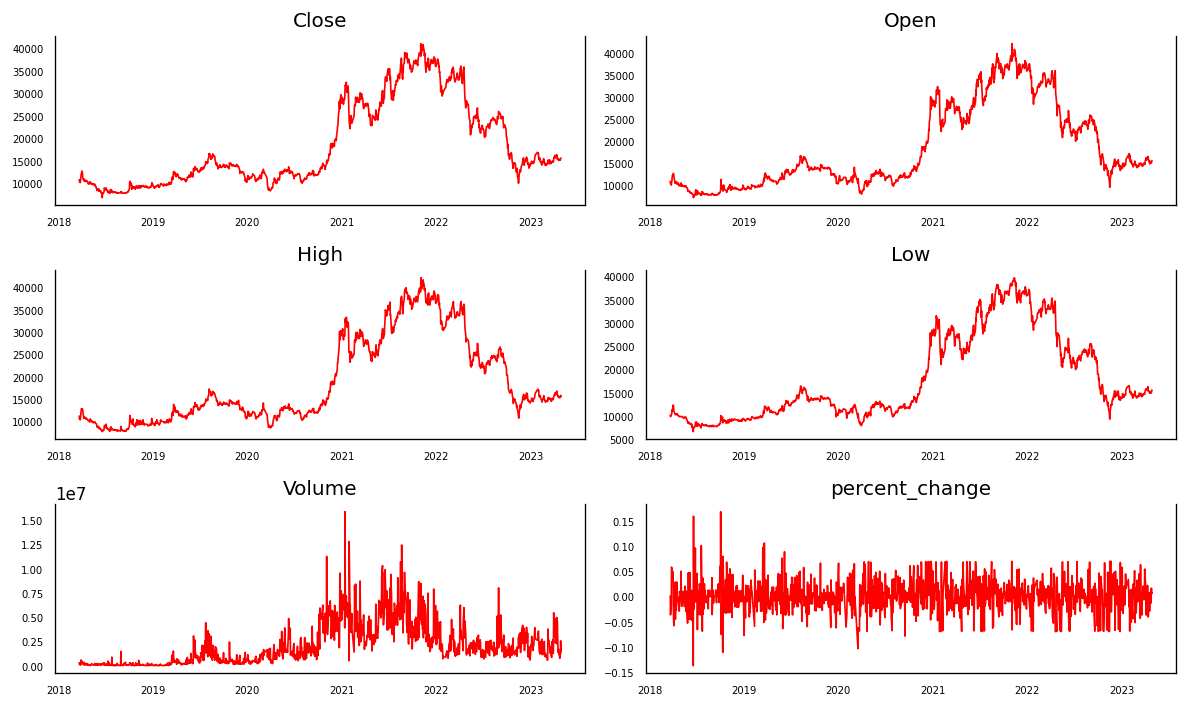

In [167]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [168]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.000,0.0002,0.0001,0.0047,0.0000,0.0021
Open_y,0.000,1.0000,0.0000,0.0000,0.0000,0.0000
High_y,0.000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.000,0.0000,0.0000,0.0000,1.0000,0.0004
percent_change_y,0.094,0.1694,0.1625,0.1002,0.1667,1.0000


In [169]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  774.46    > 83.9383   =>   True
Open   ::  528.97    > 60.0627   =>   True
High   ::  321.82    > 40.1749   =>   True
Low    ::  127.23    > 24.2761   =>   True
Volume ::  38.12     > 12.3212   =>   True
percent_change ::  0.31      > 4.1296    =>   False


In [170]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(889, 6)
(254, 6)
(127, 6)


In [171]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [172]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6578
 No. Lags Chosen       = 12
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.989. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5798
 No. Lags Chosen       = 11
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9871. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [173]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [174]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.01
 No. Lags Chosen       = 11
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1578
 No. Lags Chosen       = 10
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [175]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [176]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.4805
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3445
 No. Lags Chosen       = 20
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [177]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  70.88512291041954
BIC :  71.11203274329246
FPE :  6.095629831340162e+30
HQIC:  70.97186924701747 

Lag Order = 2
AIC :  69.2159434006788
BIC :  69.6377240066795
FPE :  1.1484386115926646e+30
HQIC:  69.37719644049727 

Lag Order = 3
AIC :  68.27551189888858
BIC :  68.89251201782601
FPE :  4.484306822483239e+29
HQIC:  68.5114130454084 

Lag Order = 4
AIC :  67.6304104008374
BIC :  68.4429798007135
FPE :  2.352629242455668e+29
HQIC:  67.94110148496819 

Lag Order = 5
AIC :  67.19060822026621
BIC :  68.19909770146492
FPE :  1.5156044375668216e+29
HQIC:  67.57623150211113 

Lag Order = 6
AIC :  66.87654541796427
BIC :  68.08130681746238
FPE :  1.1072443256170431e+29
HQIC:  67.3372435885941 

Lag Order = 7
AIC :  66.68645784677258
BIC :  68.0878440423724
FPE :  9.157219555720284e+28
HQIC:  67.222374030009 

Lag Order = 8
AIC :  66.50637293828645
BIC :  68.10473785287056
FPE :  7.649838579557028e+28
HQIC:  67.11765069249465 

Lag Order = 9
AIC :  66.23096826365422
BIC :  

In [178]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,74.81,74.84,3.092e+32,74.82
1,70.94,71.17,6.416e+30,71.02
2,69.26,69.69,1.205e+30,69.43
3,68.32,68.95,4.681e+29,68.56
4,67.67,68.49,2.441e+29,67.98
5,67.23,68.25,1.575e+29,67.62
6,66.91,68.13,1.145e+29,67.38
7,66.72,68.14,9.495e+28,67.27
8,66.54,68.16,7.938e+28,67.16
9,66.27,68.09*,6.066e+28,66.97


In [179]:
model_fitted = model.fit(10)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Jun, 2023
Time:                     23:02:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    68.1011
Nobs:                     877.000    HQIC:                   66.8701
Log likelihood:          -36088.7    FPE:                5.13798e+28
AIC:                      66.1077    Det(Omega_mle):     3.43220e+28
--------------------------------------------------------------------
Results for equation Close
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.358822        18.986389            0.019           0.985
L1.Close                  -0.760205         0.085179           -8.925           0.000
L1.Open                   -0.004748     

In [180]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

10


array([[-4.900e+01, -7.310e+02,  9.800e+01, -6.330e+02,  3.700e+05,
         1.540e-02],
       [ 0.000e+00,  3.410e+02, -1.960e+02, -1.470e+02,  1.190e+06,
         1.400e-03],
       [-8.770e+02, -6.330e+02, -3.890e+02, -4.860e+02, -1.710e+06,
        -2.350e-02],
       [ 6.820e+02, -2.920e+02,  0.000e+00,  2.910e+02,  8.000e+04,
         4.200e-02],
       [-1.460e+02,  4.870e+02,  4.900e+01,  1.000e+00,  2.400e+06,
        -2.240e-02],
       [-2.920e+02, -6.820e+02, -3.900e+02, -4.390e+02, -4.180e+06,
        -3.900e-03],
       [ 1.168e+03,  6.330e+02,  1.558e+03,  7.310e+02,  4.780e+06,
         3.980e-02],
       [-1.070e+03,  5.840e+02, -8.760e+02, -1.460e+02, -3.900e+06,
        -6.110e-02],
       [-1.470e+02, -1.119e+03, -3.900e+02, -1.950e+02,  1.980e+06,
         2.520e-02],
       [ 0.000e+00, -1.000e+00, -7.790e+02, -5.840e+02, -8.500e+05,
         4.000e-03]])

In [181]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-10-20,-67.205355,150.145405,901.519170,328.753323,543760.526176,-0.003211
2021-10-21,313.657801,-54.016388,-131.315299,131.415778,-349400.954957,0.021973
2021-10-22,-19.705886,111.356046,36.136692,-83.823324,-210113.665104,-0.018191
2021-10-25,197.498593,254.507374,284.510753,132.351303,701563.835116,0.003903
2021-10-26,-115.282701,-209.521827,-156.120707,69.489992,-140854.160118,-0.003718
...,...,...,...,...,...,...
2022-10-19,0.074739,0.003338,0.025731,0.025130,46.700466,0.000006
2022-10-20,0.074739,0.003338,0.025731,0.025130,46.700730,0.000006
2022-10-21,0.074740,0.003338,0.025731,0.025130,46.700285,0.000006


In [182]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-10-26,-67.205355,150.145405,901.519170,328.753323,543760.526176,-0.003211
2022-10-27,313.657801,-54.016388,-131.315299,131.415778,-349400.954957,0.021973
2022-10-28,-19.705886,111.356046,36.136692,-83.823324,-210113.665104,-0.018191
2022-10-31,197.498593,254.507374,284.510753,132.351303,701563.835116,0.003903
2022-11-01,-115.282701,-209.521827,-156.120707,69.489992,-140854.160118,-0.003718
...,...,...,...,...,...,...
2023-04-24,0.067332,-0.000254,0.021718,0.018281,59.101431,0.000005
2023-04-25,0.071479,-0.002632,0.020294,0.018409,44.778977,0.000006
2023-04-26,0.075127,0.002066,0.023094,0.024211,32.935568,0.000006


In [183]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [184]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [185]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-10-26,36115.794645,36576.145405,36743.519170,35976.753323,4.083761e+06,-0.012411
2022-10-27,36021.247092,36282.274422,36539.723040,35852.922425,3.988120e+06,0.006350
2022-10-28,35906.993652,36099.759484,36372.063603,35645.268203,3.682366e+06,0.006921
2022-10-31,35990.238805,36171.751921,36488.914918,35569.965284,4.078176e+06,0.011394
2022-11-01,35958.201258,36034.222530,36449.645527,35564.152356,4.333131e+06,0.012150
...,...,...,...,...,...,...
2023-04-24,23996.723195,22829.375814,23478.755069,23123.063774,9.827297e+06,0.228185
2023-04-25,23900.053641,22717.013999,23370.532775,23018.510273,9.878130e+06,0.230381
2023-04-26,23803.459215,22604.654250,23262.333575,22913.980983,9.928996e+06,0.232582


In [186]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-10-20,36115.794645,36576.145405,36743.519170,35976.753323,4.083761e+06,-0.012411
2021-10-21,36021.247092,36282.274422,36539.723040,35852.922425,3.988120e+06,0.006350
2021-10-22,35906.993652,36099.759484,36372.063603,35645.268203,3.682366e+06,0.006921
2021-10-25,35990.238805,36171.751921,36488.914918,35569.965284,4.078176e+06,0.011394
2021-10-26,35958.201258,36034.222530,36449.645527,35564.152356,4.333131e+06,0.012150
...,...,...,...,...,...,...
2022-10-19,12318.192656,8586.366430,9940.688549,10046.110693,1.665620e+07,0.551570
2022-10-20,12231.019103,8474.430460,9835.736443,9944.750925,1.671296e+07,0.554472
2022-10-21,12143.920290,8362.497830,9730.810067,9843.416286,1.676976e+07,0.557380


In [187]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,36115.794645,36576.145405,36743.519170,35976.753323,4.083761e+06,-0.012411
1,36021.247092,36282.274422,36539.723040,35852.922425,3.988120e+06,0.006350
2,35906.993652,36099.759484,36372.063603,35645.268203,3.682366e+06,0.006921
3,35990.238805,36171.751921,36488.914918,35569.965284,4.078176e+06,0.011394
4,35958.201258,36034.222530,36449.645527,35564.152356,4.333131e+06,0.012150
...,...,...,...,...,...,...
249,12318.192656,8586.366430,9940.688549,10046.110693,1.665620e+07,0.551570
250,12231.019103,8474.430460,9835.736443,9944.750925,1.671296e+07,0.554472
251,12143.920290,8362.497830,9730.810067,9843.416286,1.676976e+07,0.557380
252,12056.896216,8250.568537,9625.909423,9742.106778,1.682662e+07,0.560294


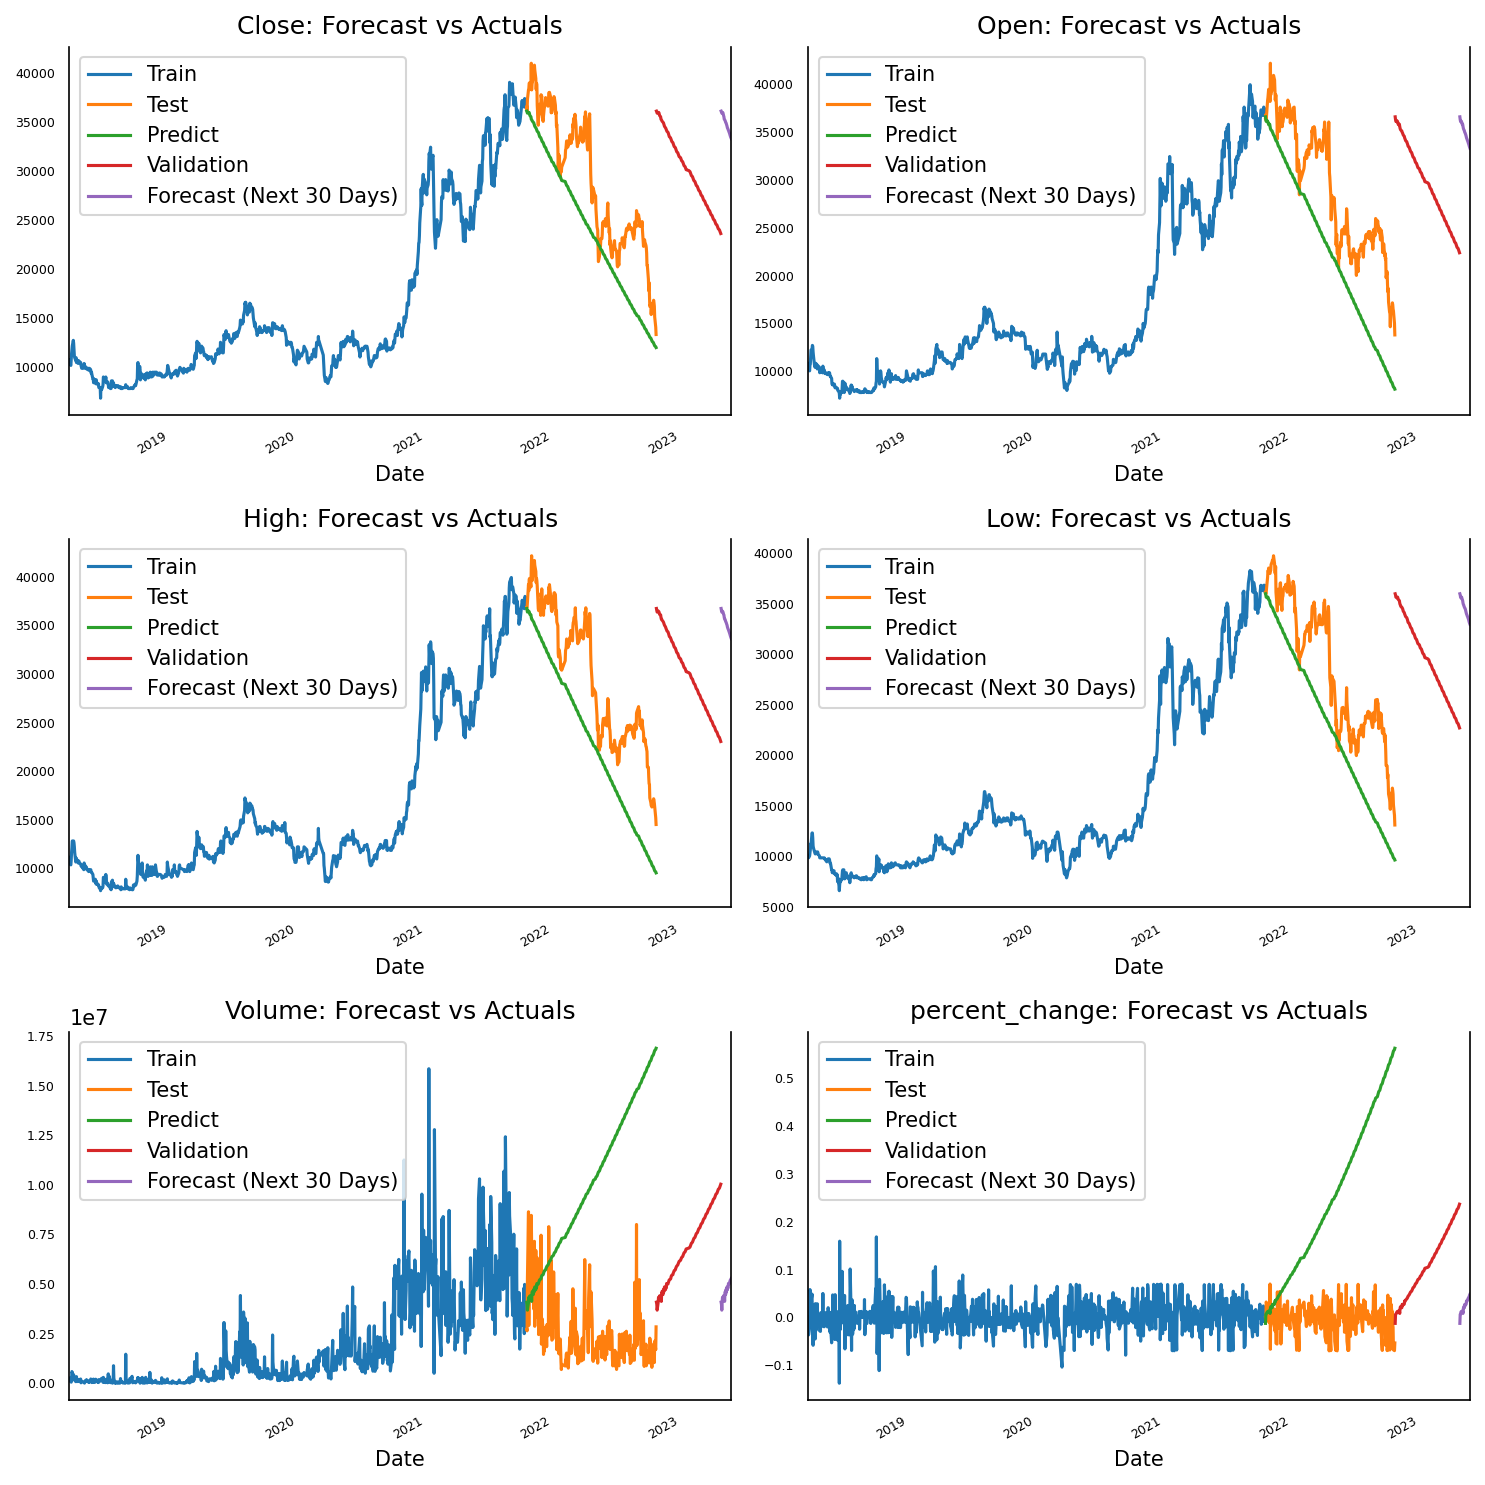

In [193]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
